In [1]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)
index0 = 0
indice = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas
    datos_composers[composer]['Indice'] = indice
    indice += 1

composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze().to_numpy().astype(float) # agregamos pieza al dicc composer con key como # serie

import copy
def midi_to_hz(midi_notes):
    # Fórmula para convertir número MIDI a Hz
    freqs = 440.0 * 2 ** ((midi_notes - 69) / 12.0)
    return freqs

# composers_interp = copy.deepcopy(composers)
composers_Hz = copy.deepcopy(composers)

# for composer in composers_Hz.keys():
#     for pieza in composers_Hz[composer].keys():
#         subject = composers[composer][pieza]
#         composers_Hz[composer][pieza] = midi_to_hz(subject)

composers_Hz_depurado = copy.deepcopy(composers_Hz)
datos_composers_Hz_depurado = copy.deepcopy(datos_composers)

for i,composer in enumerate(composers_Hz.keys()):
    d = 0
    for pieza in composers_Hz[composer].keys():
        if len(composers_Hz[composer][pieza])//2 < 400:
            del composers_Hz_depurado[composer][pieza]
            d = d + 1
    datos_composers_Hz_depurado[composer]['# Piezas'] = datos_composers[composer]['# Piezas'] - d


# 40 promedio de numero de piezas por compositor
composers_Hz_depurado_v2 = copy.deepcopy(composers_Hz_depurado)
composers_Hz_depurado_v2_keychange = copy.deepcopy(composers_Hz_depurado_v2)
datos_composers_Hz_depurado_v2 = copy.deepcopy(datos_composers_Hz_depurado)

for composer in composers.keys():
    if datos_composers_Hz_depurado[composer]['# Piezas'] < 30:
        del composers_Hz_depurado_v2[composer]
        del datos_composers_Hz_depurado_v2[composer]
    
for i,composer in enumerate(composers_Hz_depurado_v2.keys()):
    datos_composers_Hz_depurado_v2[composer]['Indice'] = i 

for composer in composers_Hz_depurado_v2.keys():
    for i,serie in enumerate(composers_Hz_depurado_v2[composer].keys()):
        composers_Hz_depurado_v2_keychange[composer]['Serie_' + str(i+1)] = composers_Hz_depurado_v2_keychange[composer].pop(serie)

print(" # de compositores restantes: ", len(composers_Hz_depurado_v2))

 # de compositores restantes:  19


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import fathon
from fathon import fathonUtils as fu

def DFA_logbin(time_series):
    # Convertir la serie temporal a un formato compatible con Fathon
    my_data = fu.toAggregated(time_series)
    data_length = len(my_data)

    # Definir tamaños de ventana
    winSizes = fu.linRangeByStep(20, min(500, data_length // 4))  # Ajusta los límites según los datos
    revSeg = False  # Si deseas usar segmentos invertidos
    polOrd = 2  # Orden del polinomio para eliminar tendencias

    # Crear el objeto DFA y calcular las fluctuaciones
    pydfa = fathon.DFA(my_data)
    n, F = pydfa.computeFlucVec(winSizes, revSeg=revSeg, polOrd=polOrd)

    # Aplicar log-binning
    log_bins = np.logspace(np.log10(min(n)), np.log10(max(n)), num=15)
    binned_F = []
    binned_n = []
    for i in range(len(log_bins) - 1):
        mask = (n >= log_bins[i]) & (n < log_bins[i + 1])
        if np.any(mask):
            binned_n.append(np.mean(n[mask]))
            binned_F.append(np.mean(F[mask]))

    return binned_n, binned_F


In [4]:
import numpy as np
import os
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

def calculate_increment_series(time_series):
    """Calcula la serie de incrementos."""
    return np.diff(time_series)

def decompose_series(increment_series):
    """Descompone la serie de incrementos en magnitudes y signos, y resta las medias."""
    magnitude_series = np.abs(increment_series)
    sign_series = np.sign(increment_series)
    
    # Restar las medias
    magnitude_series -= np.mean(magnitude_series)
    sign_series -= np.mean(sign_series)
    
    return magnitude_series, sign_series

def integrate_series(series):
    """Integra la serie para asegurar que esté positivamente correlacionada."""
    return np.cumsum(series)


def mdfa(time_series):
    """
    Implementación del MDFA siguiendo los pasos especificados.
    :param time_series: Serie temporal (numpy array).
    :param scale_range: Rango de tamaños de ventana para el análisis de escala.
    :return: Exponentes de escala para la serie de magnitudes y signos.
    """
    # Paso 1: Calcular la serie de incrementos
    increment_series = calculate_increment_series(time_series)
    
    # Paso 2: Descomponer la serie de incrementos en magnitud y signo, restar medias
    magnitude_series, sign_series = decompose_series(increment_series)
    
    # Paso 3: Integrar las series de magnitudes y signos
    integrated_magnitude = integrate_series(magnitude_series)
    integrated_sign = integrate_series(sign_series)
    
    # Paso 4: Aplicar DFA a ambas series integradas
    n_mag, F_mag = DFA_logbin(integrated_magnitude)
    # alpha_sign = DFA(integrated_sign)

    
    return n_mag, F_mag

In [5]:
#! /usr/bin/env python3
"""
iaaft - Iterative amplitude adjusted Fourier transform surrogates

        This module implements the IAAFT method [1] to generate time series
        surrogates (i.e. randomized copies of the original time series) which
        ensures that each randomised copy preserves the power spectrum of the
        original time series.

[1] Venema, V., Ament, F. & Simmer, C. A stochastic iterative amplitude
    adjusted Fourier Transform algorithm with improved accuracy (2006), Nonlin.
    Proc. Geophys. 13, pp. 321--328
    https://doi.org/10.5194/npg-13-321-2006

"""
# Created: Tue Jun 22, 2021  09:44am
# Last modified: Tue Jun 22, 2021  12:39pm
#
# Copyright (C) 2021  Bedartha Goswami <bedartha.goswami@uni-tuebingen.de> This
# program is free software: you can redistribute it and/or modify it under the
# terms of the GNU Affero General Public License as published by the Free
# Software Foundation, either version 3 of the License, or (at your option) any
# later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------


import numpy as np
from tqdm import tqdm


def iaaft(x, ns, tol_pc=5., verbose=True, maxiter=1E6, sorttype="quicksort"):
    """
    Returns iAAFT surrogates of given time series.

    Parameter
    ---------
    x : numpy.ndarray, with shape (N,)
        Input time series for which IAAFT surrogates are to be estimated.
    ns : int
        Number of surrogates to be generated.
    tol_pc : float
        Tolerance (in percent) level which decides the extent to which the
        difference in the power spectrum of the surrogates to the original
        power spectrum is allowed (default = 5).
    verbose : bool
        Show progress bar (default = `True`).
    maxiter : int
        Maximum number of iterations before which the algorithm should
        converge. If the algorithm does not converge until this iteration
        number is reached, the while loop breaks.
    sorttype : string
        Type of sorting algorithm to be used when the amplitudes of the newly
        generated surrogate are to be adjusted to the original data. This
        argument is passed on to `numpy.argsort`. Options include: 'quicksort',
        'mergesort', 'heapsort', 'stable'. See `numpy.argsort` for further
        information. Note that although quick sort can be a bit faster than 
        merge sort or heap sort, it can, depending on the data, have worse case
        spends that are much slower.

    Returns
    -------
    xs : numpy.ndarray, with shape (ns, N)
        Array containing the IAAFT surrogates of `x` such that each row of `xs`
        is an individual surrogate time series.

    See Also
    --------
    numpy.argsort

    """
    # as per the steps given in Lancaster et al., Phys. Rep (2018)
    nx = x.shape[0]
    xs = np.zeros((ns, nx))
    maxiter = 10000
    ii = np.arange(nx)

    # get the fft of the original array
    x_amp = np.abs(np.fft.fft(x))
    x_srt = np.sort(x)
    r_orig = np.argsort(x)

    # loop over surrogate number
    pb_fmt = "{desc:<5.5}{percentage:3.0f}%|{bar:30}{r_bar}"
    pb_desc = "Estimating IAAFT surrogates ..."
    for k in tqdm(range(ns), bar_format=pb_fmt, desc=pb_desc,
                  disable=not verbose):

        # 1) Generate random shuffle of the data
        count = 0
        r_prev = np.random.permutation(ii)
        r_curr = r_orig
        z_n = x[r_prev]
        percent_unequal = 100.

        # core iterative loop
        while (percent_unequal > tol_pc) and (count < maxiter):
            r_prev = r_curr

            # 2) FFT current iteration yk, and then invert it but while
            # replacing the amplitudes with the original amplitudes but
            # keeping the angles from the FFT-ed version of the random
            y_prev = z_n
            fft_prev = np.fft.fft(y_prev)
            phi_prev = np.angle(fft_prev)
            e_i_phi = np.exp(phi_prev * 1j)
            z_n = np.fft.ifft(x_amp * e_i_phi)

            # 3) rescale zk to the original distribution of x
            r_curr = np.argsort(z_n, kind=sorttype)
            z_n[r_curr] = x_srt.copy()
            percent_unequal = ((r_curr != r_prev).sum() * 100.) / nx

            # 4) repeat until number of unequal entries between r_curr and 
            # r_prev is less than tol_pc percent
            count += 1

        if count >= (maxiter - 1):
            print("maximum number of iterations reached!")

        xs[k] = np.real(z_n)

    return xs



In [6]:
def ajuste_polinomial(x, y, grado):
    """
    Ajusta un polinomio de grado especificado a los datos y grafica el ajuste.
    
    :param x: Array de valores x de los datos.
    :param y: Array de valores y de los datos.
    :param grado: Grado del polinomio a ajustar.
    :return: Coeficientes del polinomio ajustado.
    """
    # Ajustar el polinomio usando np.polyfit
    coeficientes = np.polyfit(x, y, grado)
    
    # Crear un polinomio a partir de los coeficientes ajustados
    polinomio = np.poly1d(coeficientes)
    
    # Evaluar el polinomio ajustado en los puntos x
    y_ajustado = polinomio(x)
    
    # Retornar los coeficientes del polinomio
    return y_ajustado, coeficientes

def evaluar_derivada(coeficientes, x_valor):
    """
    Calcula la primera derivada de un polinomio y la evalúa en un valor arbitrario.
    
    :param coeficientes: Coeficientes del polinomio (array).
    :param x_valor: Valor en el que se desea evaluar la derivada.
    :return: Valor de la primera derivada del polinomio evaluada en x_valor.
    """
    # Crear el polinomio a partir de los coeficientes
    polinomio = np.poly1d(coeficientes)
    
    # Calcular la primera derivada del polinomio
    derivada = np.polyder(polinomio)
    
    # Evaluar la derivada en el valor especificado
    derivada_evaluada = derivada(x_valor)
    return np.array(derivada_evaluada)

In [12]:
import piecewise_regression

# CARGAR DATOS

def main(time_series, method):
    H = []
    # CALCULAR MDFA Ó DFA
    if method == 'MDFA':
        n, F = mdfa(time_series)
    if method == 'DFA':
        n, F = DFA_logbin(time_series)


    # GENERAR SURROGADOS
    flucts_surrogates = []
    N = 200
    surrogates = iaaft(time_series, N)
    for i in range(N):
        if method == 'MDFA':
            n_surr, flucts_surr = mdfa(surrogates[i,:])
        if method == 'DFA':
            n_surr, flucts_surr = DFA_logbin(surrogates[i,:])
        flucts_surrogates.append(np.log10(flucts_surr))
    flucts_surrogates = np.vstack(flucts_surrogates)

    # AJUSTAR REGRESIÓN LINEAL SEGMENTADA
    # n_breakpoints = 1
    # while True: 
    #     pw_fit = piecewise_regression.Fit(np.log10(n), np.log10(F), n_breakpoints=n_breakpoints)
    #     pw_results = pw_fit.get_results()
    #     pw_estimates = pw_results["estimates"]

    #     if pw_results['converged']:
    #         print('converged')
    #         break
    #     elif n_breakpoints != 1:
    #         n_breakpoints= n_breakpoints-1
    #     else: 
    #         print("Not converged")
    #         break
    # if pw_results['converged']:
    #     for value in pw_estimates:
    #         if 'alpha' in value:
    #             H.append(pw_estimates[value]['estimate'])

    # # GRAFICAR
    # if pw_results['converged']:
    #     pw_fit.plot_data(color="red", s=1,label='log(F(s))') # logF(s)
    #     pw_fit.plot_breakpoints() #Breakpoints

    lower_bound = np.min(flucts_surrogates, axis=0) # area sombreada surr
    upper_bound = np.max(flucts_surrogates, axis=0) # area sombreada surr
    plt.fill_between(np.log10(n_surr), lower_bound, upper_bound, color='blue', alpha=0.2, label='Surrogates')
    
    # AJUSTAR POLINOMIO CON GRADO # DE BREAKPOINTS
    y_ajustado, coeficientes= ajuste_polinomial(np.log10(n), np.log10(F),grado=4)
    # yˆ(xi)
    derivadas = evaluar_derivada(coeficientes, np.log10(n))

    # Derivadas para surrogados
    derivadas_surr = np.zeros([N,len(np.log10(n_surr))])
    for surr_index in range(N):
        y_ajustado_surr, coeficientes_surr = ajuste_polinomial(np.log10(n_surr), flucts_surrogates[surr_index],grado=4)
        derivadas_surr[surr_index,:] = evaluar_derivada(coeficientes_surr, np.log10(n_surr))
    derivadas_surr_mean = np.mean(derivadas_surr, axis=0)
    derivadas_surr_std = np.std(derivadas_surr, axis= 0)

    # GrAFICAR POLINOMIO
    plt.plot(np.log10(n), y_ajustado, color='green', label=f'Ajuste polinomial (grado 4)')
    plt.plot(np.log10(n), np.log10(F), color='red',ls='',mew=0.5,marker='.', label=f'F(s)')

    plt.xlabel('log(s)', fontsize=14)
    plt.ylabel('log(F(s))', fontsize=14)
    plt.title('DFA', fontsize=14)
    plt.legend(loc=0, fontsize=7)
    plt.show()
    plt.close()


    plt.figure()
    plt.plot(np.log10(n), derivadas, color='green', ls='',marker='.',label='Derivadas de la serie original')
    plt.fill_between(
        np.log10(n_surr), 
        derivadas_surr_mean - derivadas_surr_std, 
        derivadas_surr_mean + derivadas_surr_std, 
        color='blue', alpha=0.2, label='Surrogates: Mean ± Std'
    )
    plt.xlabel('log(s)', fontsize=14)
    plt.ylabel("Derivada del polinomio", fontsize=14)
    plt.title("Derivadas del ajuste polinomial vs log(s)", fontsize=14)
    plt.legend(loc=0, fontsize=10)
    plt.show()

    # CALCULAR INDICE NO LINEALIDAD
    E = np.sum(np.abs(derivadas - derivadas_surr_mean) / derivadas_surr_std)
    E_index = E/len(derivadas)
    return E_index

In [11]:
# for composer in composers_Hz_depurado_v2.keys():
#     xi_index = np.zeros((datos_composers_Hz_depurado_v2[composer]['# Piezas'], 2))
#     for i, serie in enumerate(composers_Hz_depurado_v2[composer].keys()): 
#         print(composer,serie)
#         # if int(serie.split('_')[1]) < 413:
#         #     print(serie)
#         #     continue
#         subject = composers_Hz_depurado_v2[composer][serie]
#         xi_index[i,0] = int(serie.split('_')[1])
#         xi_index[i,1] = main(subject, 'DFA')
#         print(xi_index[i,1])
#     np.save('xi_index1_dfa/'+str(datos_composers_Hz_depurado_v2[composer]['Birth_year'])+'_'+str(composer)+'_xi.npy', xi_index)

dict_keys(['Serie_1', 'Serie_3', 'Serie_4', 'Serie_5', 'Serie_6', 'Serie_7', 'Serie_10', 'Serie_11', 'Serie_12', 'Serie_15', 'Serie_16', 'Serie_19', 'Serie_22', 'Serie_25', 'Serie_30', 'Serie_62', 'Serie_63', 'Serie_64', 'Serie_65', 'Serie_66', 'Serie_67', 'Serie_68', 'Serie_69', 'Serie_70', 'Serie_71', 'Serie_72', 'Serie_73', 'Serie_74', 'Serie_75', 'Serie_77', 'Serie_80', 'Serie_82', 'Serie_83', 'Serie_84', 'Serie_85', 'Serie_87', 'Serie_91', 'Serie_92', 'Serie_93', 'Serie_94', 'Serie_95', 'Serie_96', 'Serie_101', 'Serie_103', 'Serie_104', 'Serie_105', 'Serie_106', 'Serie_107', 'Serie_108', 'Serie_114', 'Serie_115', 'Serie_170', 'Serie_171', 'Serie_172', 'Serie_173', 'Serie_182', 'Serie_184', 'Serie_185', 'Serie_186', 'Serie_187', 'Serie_188', 'Serie_189', 'Serie_190', 'Serie_191', 'Serie_192', 'Serie_193', 'Serie_194', 'Serie_195', 'Serie_196', 'Serie_197', 'Serie_198', 'Serie_199', 'Serie_200', 'Serie_201', 'Serie_202', 'Serie_203', 'Serie_204', 'Serie_205', 'Serie_208', 'Serie_209

Estim  0%|                              | 0/200 [00:00<?, ?it/s]

Estim100%|██████████████████████████████| 200/200 [00:00<00:00, 259.66it/s]


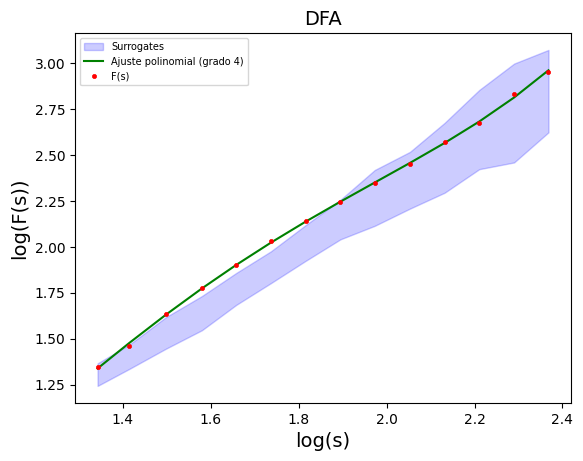

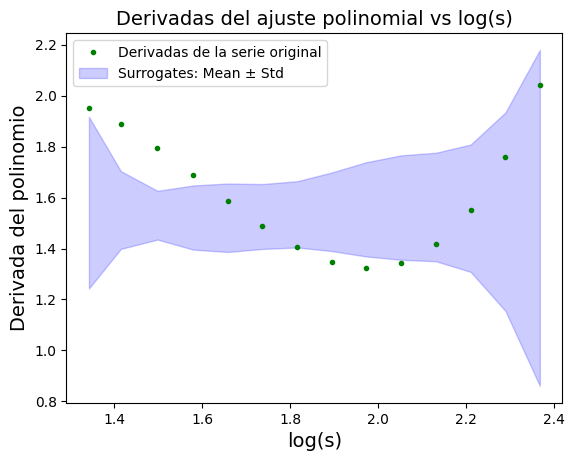

1.0593816783310352 Serie_80 Beethoven
2271


Estim100%|██████████████████████████████| 200/200 [00:01<00:00, 112.99it/s]


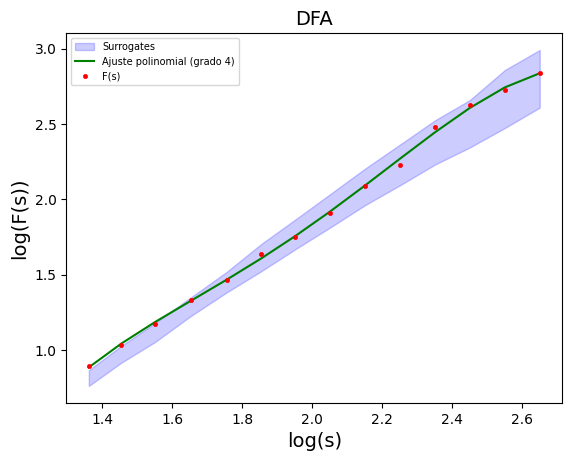

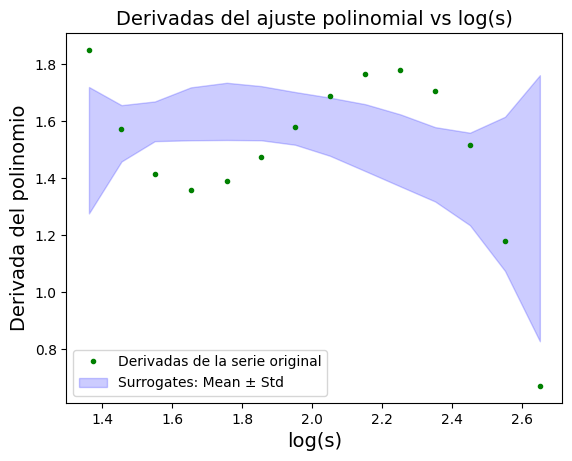

1.5353418654419786 Serie_14 Mozart


In [14]:
print(composers_Hz_depurado_v2['Beethoven'].keys())
for composer, serie in zip(['Beethoven','Mozart'],['Serie_80','Serie_14']):
    subject = composers[composer][serie]
    print(len(subject))
    E = main(subject, 'MDFA')
    print(E,serie,composer)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import fathon
from fathon import fathonUtils as fu

def DFA(time_series):

    # Cargar tus datos en lugar de los generados aleatoriamente
    # Reemplaza esta línea con la carga de tus datos reales
    my_data = time_series  # Reemplaza esta línea con tus datos reales

    # Convertir la serie a un formato compatible con Fathon
    my_data = fu.toAggregated(my_data)

    # Determinar la longitud de la serie temporal
    data_length = len(my_data)

    # Ajustar los tamaños de ventana para que no excedan la longitud de los datos
    winSizes = fu.linRangeByStep(20, min(500, data_length // 4))  # Ajusta según la longitud de tus datos
    revSeg = False  # Configura si deseas usar segmentos invertidos
    polOrd = 2 # Orden del polinomio para eliminar la tendencia, ajusta según tu cas3

    # Crear el objeto DFA con tus datos
    pydfa = fathon.DFA(my_data)

    # Calcular las fluctuaciones
    n, F = pydfa.computeFlucVec(winSizes, revSeg=revSeg, polOrd=polOrd)


    # # Si deseas realizar ajustes múltiples en diferentes rangos, configura los límites aquí
    # limits_list = np.array([[20, min(50, data_length // 4)]], dtype=int)  # Ajusta según sea necesario
    # list_H, list_H_intercept = pydfa.multiFitFlucVec(limits_list)

    # # Graficar los resultados de los múltiples ajustes
    # clrs = ['k', 'b', 'm', 'c', 'y']
    # stls = ['-', '--', '.-']

    return n, F


In [55]:
def mdfa(time_series):
    """
    Implementación del MDFA siguiendo los pasos especificados.
    :param time_series: Serie temporal (numpy array).
    :param scale_range: Rango de tamaños de ventana para el análisis de escala.
    :return: Exponentes de escala para la serie de magnitudes y signos.
    """
    # Paso 1: Calcular la serie de incrementos
    increment_series = calculate_increment_series(time_series)
    
    # Paso 2: Descomponer la serie de incrementos en magnitud y signo, restar medias
    magnitude_series, sign_series = decompose_series(increment_series)
    
    # Paso 3: Integrar las series de magnitudes y signos
    integrated_magnitude = integrate_series(magnitude_series)
    integrated_sign = integrate_series(sign_series)
    
    # Paso 4: Aplicar DFA a ambas series integradas
    n_mag, F_mag = DFA(integrated_magnitude)
    # alpha_sign = DFA(integrated_sign)

    
    return n_mag, F_mag

In [56]:
import piecewise_regression

# CARGAR DATOS

def main(time_series, method):
    H = []
    # CALCULAR MDFA Ó DFA
    if method == 'MDFA':
        n, F = mdfa(time_series)
    if method == 'DFA':
        n, F = DFA(time_series)


    # GENERAR SURROGADOS
    flucts_surrogates = []
    N = 100
    surrogates = iaaft(time_series, N)
    for i in range(N):
        if method == 'MDFA':
            n_surr, flucts_surr = mdfa(surrogates[i,:])
        if method == 'DFA':
            n_surr, flucts_surr = DFA(surrogates[i,:])
        flucts_surrogates.append(np.log10(flucts_surr))
    flucts_surrogates = np.vstack(flucts_surrogates)

    # AJUSTAR REGRESIÓN LINEAL SEGMENTADA
    n_breakpoints = 1
    while True: 
        pw_fit = piecewise_regression.Fit(np.log10(n), np.log10(F), n_breakpoints=n_breakpoints)
        pw_results = pw_fit.get_results()
        pw_estimates = pw_results["estimates"]

        if pw_results['converged']:
            print('converged')
            break
        elif n_breakpoints != 1:
            n_breakpoints= n_breakpoints-1
        else: 
            print("Not converged")
            break
    if pw_results['converged']:
        for value in pw_estimates:
            if 'alpha' in value:
                H.append(pw_estimates[value]['estimate'])

    # # GRAFICAR

    # pw_fit.plot_data(color="red", s=1,label='log(F(s))') # logF(s)
    # pw_fit.plot_breakpoints() #Breakpoints

    # lower_bound = np.min(flucts_surrogates, axis=0) # area sombreada surr
    # upper_bound = np.max(flucts_surrogates, axis=0) # area sombreada surr
    # plt.fill_between(np.log10(n_surr), lower_bound, upper_bound, color='blue', alpha=0.2, label='Surrogates')
    
    # AJUSTAR POLINOMIO CON GRADO # DE BREAKPOINTS
    past_idx = 0
    derivadas = np.array([])
    y_ajustados = np.array([])
    if pw_results['converged']:
        for i in range(n_breakpoints):
            pts = pw_estimates[f'breakpoint{i + 1}']['estimate']
            idx_closest = int(np.argmin(np.abs(np.log10(n) - pts)))
            y_ajustado, coeficientes = ajuste_polinomial(np.log10(n)[past_idx:idx_closest+1], np.log10(F)[past_idx:idx_closest+1], grado=1)
            derivadas = np.concatenate((derivadas,evaluar_derivada(coeficientes, np.log10(n)[past_idx:idx_closest+1])))
            y_ajustados = np.concatenate((y_ajustados,y_ajustado))    
            past_idx = idx_closest+1
    # ultimo segmento
    y_ajustado, coeficientes = ajuste_polinomial(np.log10(n)[past_idx:], np.log10(F)[past_idx:], grado=1)
    derivadas = np.concatenate((derivadas,evaluar_derivada(coeficientes, np.log10(n)[past_idx:])))
    y_ajustados = np.concatenate((y_ajustados,y_ajustado))    

    # Derivadas para surrogados
    derivadas_surr = np.zeros([N, len(np.log10(n_surr))])
    for surr_index in range(N):
        past_idx_surr = 0
        if pw_results['converged']:
            for i in range(n_breakpoints):
                pts_surr = pw_estimates[f'breakpoint{i + 1}']['estimate']
                idx_closest_surr = np.argmin(np.abs(np.log10(n_surr) - pts_surr))
                y_ajustado_surr, coeficientes_surr = ajuste_polinomial(
                    np.log10(n_surr)[past_idx_surr:idx_closest_surr+1],
                    flucts_surrogates[surr_index, past_idx_surr:idx_closest_surr+1],
                    grado=1
                )
                derivadas_surr[surr_index, past_idx_surr:idx_closest_surr+1] = evaluar_derivada(
                    coeficientes_surr, np.log10(n_surr)[past_idx_surr:idx_closest_surr+1]
                )
                past_idx_surr = idx_closest_surr+1

        # último segmento del surrogate
        y_ajustado_surr, coeficientes_surr = ajuste_polinomial(
            np.log10(n_surr)[past_idx_surr:],
            flucts_surrogates[surr_index, past_idx_surr:],
            grado=1
        )
        derivadas_surr[surr_index, past_idx_surr:] = evaluar_derivada(
            coeficientes_surr, np.log10(n_surr)[past_idx_surr:]
        )

    derivadas_surr_mean = np.mean(derivadas_surr, axis=0)
    derivadas_surr_std = np.std(derivadas_surr, axis=0)

    # GrAFICAR POLINOMIO
    # plt.plot(np.log10(n), y_ajustados, color='green', label=f'Ajuste polinomial (grado {n_breakpoints+1})')

    # plt.xlabel('log(s)', fontsize=14)
    # plt.ylabel('log(F(s))', fontsize=14)
    # plt.title('DFA', fontsize=14)
    # plt.legend(loc=0, fontsize=7)
    # plt.show()
    # plt.close()


    # plt.figure()
    # plt.plot(np.log10(n), derivadas, color='green', ls='',marker='.',label='Derivadas de la serie original')
    # plt.fill_between(
    #     np.log10(n_surr), 
    #     derivadas_surr_mean - derivadas_surr_std, 
    #     derivadas_surr_mean + derivadas_surr_std, 
    #     color='blue', alpha=0.2, label='Surrogates: Mean ± Std'
    # )
    # plt.xlabel('log(s)', fontsize=14)
    # plt.ylabel("Derivada del polinomio", fontsize=14)
    # plt.title("Derivadas del ajuste polinomial vs log(s)", fontsize=14)
    # plt.legend(loc=0, fontsize=10)
    # plt.show()

    # CALCULAR INDICE NO LINEALIDAD
    E = np.sum(np.abs(derivadas - derivadas_surr_mean) / derivadas_surr_std)
    E_index = E/len(derivadas)
    return E_index

In [27]:
# for composer in composers_Hz_depurado_v2.keys():
#     xi_index = np.zeros((datos_composers_Hz_depurado_v2[composer]['# Piezas'], 2))
#     for i, serie in enumerate(composers_Hz_depurado_v2[composer].keys()): 
#         # if int(serie.split('_')[1]) < 413:
#         #     print(serie)
#         #     continue
#         subject = composers_Hz_depurado_v2[composer][serie]
#         xi_index[i,0] = int(serie.split('_')[1])
#         xi_index[i,1] = main(subject, 'MDFA')
#         print(composer,serie,xi_index[i,1])
#     np.save('xi_index2/'+str(datos_composers_Hz_depurado_v2[composer]['Birth_year'])+'_'+str(composer)+'_xi.npy', xi_index)

In [14]:
data = np.array([])
for composer in composers_Hz_depurado_v2.keys():
    for i, serie in enumerate(composers_Hz_depurado_v2[composer].keys()): 
        E = np.load('xi_index2/'+str(datos_composers_Hz_depurado_v2[composer]['Birth_year'])+'_'+str(composer)+'_xi.npy')
        data = np.concatenate((data,E[1,:]))
np.save('xi_dfa_global.npy', data)